In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as stat
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import statsmodels.api as sm
import pandas.plotting as pd_plot
import scipy as sc
from pandas import DataFrame
import statsmodels.api as sm

In [6]:
def mean_CI_data(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, std = np.mean(a), np.std(a)
    #h = se * sc.stats.t.ppf((1 + confidence) / 2., n - 1)
    h = std * 1.96 / np.sqrt(n-1)
    return m, m - h, m + h

## Exercise 5.2
The data consist of a random sample of 480 patients from the Danish Study of Functional
Disorders (DanFunD). DanFunD represents the first major longitudinal population-based
study in the field of what is commonly referred to as functional disorders or medically
unexplained illnesses. However, data will likewise be used to study other conditions,
such as cardiovascular disease, diabetes, respiratory diseases, allergy and asthma.
In this exercise we will restrict our selves to looking at the difference in forced vital
capacity (FVC) between men and women.


## Part A
### 1) Estimate the unadjusted (crude) difference in FVC between men and women.

4.781081081081082
3.419108527131783


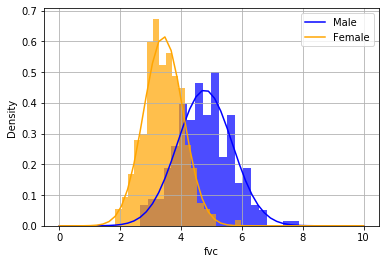

In [99]:
%matplotlib inline

danfund = pd.read_csv('data/danfund.csv', sep=';', decimal=",")
#print(danfund)

danfund_male = danfund.loc[danfund['sex'] == 1]
danfund_female = danfund.loc[danfund['sex'] == 0]

print(np.mean(danfund_male['fvc']))
print(np.mean(danfund_female['fvc']))


# plotting the histogram
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 1)

mu, std = stats.norm.fit(danfund_male['fvc'])
x = np.linspace(0,10)
pdf_data = stats.norm.pdf(x, mu, std)
ax.plot(x, pdf_data, color='blue', label='Male')
ax.hist(danfund_male['fvc'], bins=20, density='True', color='blue', alpha=0.7)

mu, std = stats.norm.fit(danfund_female['fvc'])
pdf_data = stats.norm.pdf(x, mu, std)
ax.plot(x, pdf_data, color='orange', label='Female')
ax.hist(danfund_female['fvc'], bins=20, density='True', color='orange', alpha=0.7)

ax.set_xlabel('fvc')
ax.set_ylabel('Density')
ax.legend()
ax.grid()
plt.show()


We can see a large difference in the standard deviations

In [105]:
# First, we need to test the hypothesis std_male = std_female
# F_obs = [largest observed std/ smallest observed std]^2
std_male = np.std(danfund_female['fvc'])
std_female = np.std(danfund_male['fvc'])
print('Male group: std =', std_male)
print('Female group: std =', std_female)

if std_male <= std_female:
    F_obs = (std_male/std_female)**2
else:
    F_obs = (std_female/std_male)**2

print('F_obs =', F_obs)
p_value = stats.f.cdf(F_obs, len(danfund_female['fvc']) - 1, len(danfund_female['fvc']) - 1)
print('p-value =', p_value)

Male group: std = 0.6469142466242552
Female group: std = 0.9025388128724291
F_obs = 0.5137616181498876
p-value = 6.280750320874374e-08


In [194]:
#danfund_female['diff'] = danfund_male['fvc'] - danfund_female['fvc']
t_value, p_value = stats.ttest_ind(danfund_female['fvc'],
                                   danfund_male['fvc'], equal_var=False)
print('t-value = ', t_value, '. p-value =', p_value)

ci_f = mean_CI_data(danfund_female['fvc'])
print('mean fvc (women) = ', ci_f[0], ', 95% CI = ', ci_f[1:])
ci_m = mean_CI_data(danfund_male['fvc'])
print('mean fvc (men) = ', ci_m[0], ', 95% CI = ', ci_m[1:])


import statsmodels.stats.api as sms

cm = sms.CompareMeans(sms.DescrStatsW(danfund_male['fvc']),
                      sms.DescrStatsW(danfund_female['fvc']))
ci = cm.tconfint_diff(usevar='unequal')

print('mean diff = ', ci_m[0] - ci_f[0], ', 95% CI = ', ci)

t-value =  -18.683009999073132 . p-value = 3.240780747267251e-56
mean fvc (women) =  3.419108527131783 , 95% CI =  (3.340015859223953, 3.4982011950396132)
mean fvc (men) =  4.781081081081082 , 95% CI =  (4.66208687331186, 4.900075288850304)
mean diff =  1.3619725539492986 , 95% CI =  (1.218652213778892, 1.5052928941197043)


The mean difference found was 1.36, with 95% CI (1.22, 1.50), with
p-value < 0.0001, indicating that the hypothesis of equal means is false.

### 2) For both men and women: Establish a linear regression of FVC on height and interpret the parameters in the model.


In [107]:
X = sm.add_constant(danfund_male['height']) # adding a constant - otherwise b=0 in a*x+b
Y = danfund_male['fvc']
model_male = sm.OLS(Y, X).fit()
print(model_male.summary())

Residuals_male = (danfund_male['height'] * model_male.params[1] 
             + model_male.params[0]) - danfund_male['fvc']
model_male_res = sm.OLS(Residuals_male, X).fit()

                            OLS Regression Results                            
Dep. Variable:                    fvc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     80.61
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           1.25e-16
Time:                        14:32:52   Log-Likelihood:                -257.59
No. Observations:                 222   AIC:                             519.2
Df Residuals:                     220   BIC:                             526.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.1509      1.330     -5.377      0.0

In [108]:
X = sm.add_constant(danfund_female['height']) 
Y = danfund_female['fvc']
model_female = sm.OLS(Y, X).fit()
print(model_female.summary())

Residuals_female = (danfund_female['height'] * model_female.params[1] 
             + model_female.params[0]) - danfund_female['fvc']
model_female_res = sm.OLS(Residuals_female, X).fit()


                            OLS Regression Results                            
Dep. Variable:                    fvc   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     125.1
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           6.64e-24
Time:                        14:32:52   Log-Likelihood:                -202.40
No. Observations:                 258   AIC:                             408.8
Df Residuals:                     256   BIC:                             415.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5737      0.805     -6.926      0.0

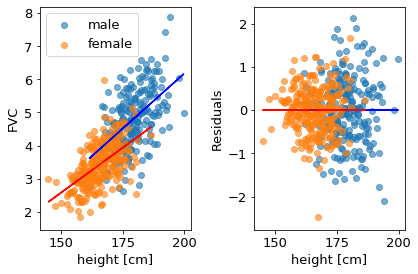

(-6.041678785169456e-15, -0.06482660396440833, 0.06482660396439625)
0.5302293470958838


In [351]:
%matplotlib inline
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2)

ax[0].scatter(danfund_male['height'], danfund_male['fvc'], color='C0', alpha=0.6, label='male')
ax[0].plot(danfund_male['height'], model_male.predict(sm.add_constant(danfund_male['height'])), color='blue')
ax[0].scatter(danfund_female['height'], danfund_female['fvc'], color='C1', alpha=0.6, label='female')
ax[0].plot(danfund_female['height'], model_female.predict(sm.add_constant(danfund_female['height'])), color='red')
ax[0].set_ylabel('FVC')
ax[0].set_xlabel('height [cm]')
ax[0].legend()

ax[1].scatter(danfund_male['height'], Residuals_male, color='C0', alpha=0.6, label='male')
ax[1].plot(danfund_male['height'], model_male_res.predict(sm.add_constant(danfund_male['height'])), color='blue')
ax[1].scatter(danfund_female['height'], Residuals_female, color='C1', alpha=0.6, label='female')
ax[1].plot(danfund_female['height'], model_female_res.predict(sm.add_constant(danfund_female['height'])), color='red')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('height [cm]')
plt.tight_layout()
plt.show()

print(mean_CI_data(Residuals_female, confidence=0.95))
print(np.std(Residuals_female))

For the male group, our model found:
- intercept: -7.1509 (95% CI  [-9.772; -4.530])
- slope: 0.0667 (95% CI  [0.052; 0.081])
- residual standard deviation: 0.7720

For the female group, our model found:
- intercept: -5.5737 (95% CI  [-7.159; -3.989])
- slope: 0.0543 (95% CI  [0.045; 0.064])
- residual standard deviation: 0.53022


*check how to get the CI for the residuals!


### 5.2.3) Establish a multiple linear regression model with FVC as the dependent variable, and height, sex and their interaction as the independent variables and interpret the parameters. Does the difference in FVC between men and women depend on the height (i.e. is there a statistically significant interaction effect)? 


In [193]:
# independent parameters; height, sex, and height * sex
# dependent parameter: fvc

danfund['height_sex'] = danfund['height'] * danfund['sex']

X = sm.add_constant(danfund[['height', 'sex', 'height_sex']])
Y = danfund['fvc']
model_multiple = sm.OLS(Y, X).fit()
print(model_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                    fvc   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     236.4
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           6.82e-94
Time:                        15:27:08   Log-Likelihood:                -476.76
No. Observations:                 480   AIC:                             961.5
Df Residuals:                     476   BIC:                             978.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5737      0.992     -5.619      0.0

We can see that the difference in slope is 0.009 (95% CI -0.005;0.029). As zero is contained in the confidence interval, we can say that the difference in FVC between men and women is independent on height

### 5.2.3)  Find a height adjusted estimate of the difference between men and women and write a short conclusion on your findings. 

In [337]:
X = sm.add_constant(danfund[['height', 'sex']])
Y = danfund['fvc']
model_multiple = sm.OLS(Y, X).fit()
print(model_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                    fvc   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     352.9
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           8.78e-95
Time:                        14:45:35   Log-Likelihood:                -477.78
No. Observations:                 480   AIC:                             961.6
Df Residuals:                     477   BIC:                             974.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5454      0.719     -9.101      0.0

We can find the height adjusted estimate by removing the interaction term: the difference is 0.5504 (95% CI 0.386, 0.715) liters, with a p-value < 0.0001.

### 5.2.3) What is the expected FVC for a man who is 180 cm tall? What is the expected FVC for a woman who is 170 cm tall (Hint: use the -lincom- command). 

In [343]:
print('The expected FVC for a 180 cm tall man is:\n')
prediction = model_multiple.get_prediction(x_180)
print(prediction.summary_frame(alpha=0.05))

print('\n')
print('The expected FVC for a 170 cm tall woman is:\n')
prediction = model.get_prediction(x_170)
print(prediction.summary_frame(alpha=0.05))


        id  sex  height   fvc  agegrp50  height_sex
0       22    0   163.0  3.18         1         0.0
1       68    0   154.5  2.58         1         0.0
2      168    0   160.5  2.83         1         0.0
3      178    0   177.0  3.83         1         0.0
4      384    0   177.0  4.02         0         0.0
..     ...  ...     ...   ...       ...         ...
475  47047    0   162.0  3.50         1         0.0
476  47160    0   165.1  3.37         0         0.0
477  47281    1   183.0  6.10         0       183.0
478  47287    0   167.5  3.43         1         0.0
479  47557    1   181.0  5.58         0       181.0

[480 rows x 6 columns]
The expected FVC for a 180 cm tall man is:



NameError: name 'x_180' is not defined

# Part B
It seems reasonable that age could also influence the FVC. Hence we add age (using the dichotomous variable agegrp50) to the multiple linear regression model established above. It is outside the scope of this course to evaluate interaction between 3 variables. We will let the model of independent effect (no interaction) between sex, height and age be given, and perform the standard model check of the model

### 1) Establish a multiple linear regression model with FVC as the dependent variable,and height, sex and age as the independent variables. What is the height and age adjusted difference in FVC between men and women? 

In [339]:
# independent parameters; height, sex, and age
# dependent parameter: fvc

X = sm.add_constant(danfund[['height', 'sex', 'agegrp50']])
Y = danfund['fvc']
model_multiple2 = sm.OLS(Y, X).fit()
print(model_multiple2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fvc   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     352.8
Date:                Thu, 08 Apr 2021   Prob (F-statistic):          1.49e-120
Time:                        14:45:57   Log-Likelihood:                -414.79
No. Observations:                 480   AIC:                             837.6
Df Residuals:                     476   BIC:                             854.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2575      0.660     -6.453      0.0

The height and age adjusted difference in FVC is 0.6803 (95% CI 0.534, 0.827)

ValueError: shapes (98,2) and (98,2) not aligned: 2 (dim 1) != 98 (dim 0)

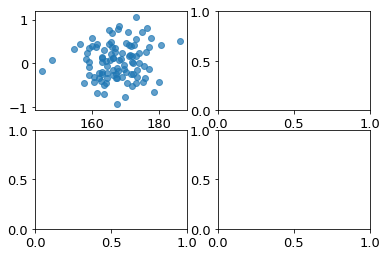

In [373]:
# checking the model assumptions


%matplotlib inline
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(2, 2)

for a in range(0,2):
    for s in range(0, 2):
        
        df = danfund.loc[danfund['sex'] == s]
        df = df.loc[danfund['agegrp50'] == a]
        
        x_subset = sm.add_constant(df[['height', 'sex', 'agegrp50']], has_constant='add')
        
        df['residual'] = model_multiple2.predict(x_subset)
        ax[a, s].scatter(df['height'], df['residual'] - df['fvc'], alpha=0.7)
        
        x_res = sm.add_constant(df['height'], has_constant='add')
        residual_fit = sm.OLS(df['residual'], x_res)
        ax[a, s].plot(df['height'], residual_fit.predict(x_res))
        
        if a == 0:
            title = str('younger')
        else:
            title = str('older')
        if s == 0:
            title = title + str(', female')
        else:
            title = title + str(', male')
        ax[a, s].set_title(title)
plt.tight_layout()
plt.show()